# Visualisation of Narrative

## Content
 - get visualisation
  - by open templates
 - file progressing 
  - extract data from book
  - split book through "Chapter"
 - extract words from book 
  - sucha as name or lacation
 - get relationship between characters and locations
 - analyse sentiment
 - calculate similarity between "Chapter"
 - put data into templates get full visualisation

### Narrative example : the bible
The bible is used for the analysis,. Bible is a novel that follows the story of jesus, a young man from Bethlehem who leaves his home to study. It will be used as a case study

The first step is to download the data to your local workspace.

In [4]:
!mkdir -p data
!curl -s -L -o data/KingJames_bible.txt https://raw.githubusercontent.com/HASSCloud/TinkerStudio-Examples/master/data/KingJames_bible.txt
!curl -s -L -o data/Bible_character.txt https://raw.githubusercontent.com/HASSCloud/TinkerStudio-Examples/master/data/Bible_character.txt
!curl -s -L -o data/Bible_Locations.txt https://raw.githubusercontent.com/HASSCloud/TinkerStudio-Examples/master/data/Bible_Locations.txt

A subdirectory or file data already exists.
Error occurred while processing: data.


### Required Libraries
The following libraries are required to run the notebook.
- You need to install several packages before using this notebook.They are Flask, textblob, NLTK and gensim respectively.

  -You can add the cell and run the code: !pip install package (here is an expample blow, and also you can just delate "#" to run the code.)

In [5]:
!pip install Flask
!pip install textblob
!pip install nltk
!pip install gensim
!pip install spacy
#!pip install ascii_letters
!pip install pandas
!pip install seaborn
!pip install matplotlib

Let's start by importing several modules that we will need.

In [6]:
# fast array operations  
import numpy as np

# natural language processing
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
from nltk import ne_chunk, pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy

# using TFIDF LSM to calculate similarities between chapter
from gensim import corpora, similarities, models

# natural language processing remove stopwords
from gensim.parsing.preprocessing import remove_stopwords
from flask import json
import os

# visualization plotting
from string import ascii_letters

# dateframe(think spreadsheet-like data) mainpulation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl


# Reading the document


Before performing the analysis, three files need to be provided for the analysis.
1. **The Narrative**. It's could be novels, articles, news, etc.
2. **Characters list**. In order to display the name of the character more accurately, it is necessary to provide the name of the character to be analyzed.
3. **List of locations**.

All these files are `.txt` file.
For this example, each file is at the root diectory. We can take a look for this example, the narrative is a `.txt` file, which is named KingJames_bible.txt



### How to change narrative

1. Get the address of the narrative file that needs to be analyzed. You need to upload the text to the Notebook workspace, to do this, click the up arrow, locate the folder where the files are stored and open them in the work book. Once this is done the code will direct the notebook to your files for analysis. 
   - For example, this example analysis text 'bible' which address is "./KingJames_bible.txt".


**NOTE! How to get file address**

**For Window OS**
If you already have the narrative or file open in Explorer, you can copy its file path to the clipboard, then paste that path into the upload dialog box. Here’s how:

 
Open Windows Explorer and find the or document in question.
Hold down the Shift key, then right-click the document.
In the context menu that appears, find and click Copy as path. This copies the file location to the clipboard. (FYI, if you don’t hold down Shift when you right-click, the Copy as path option won’t appear.)
Now, in your browser, head to Notebook or wherever, access the upload tool, and click Browse.
Press Ctrl-V to paste in the file location, then you will got the file address.

**for MAC OS**
Select the file or folder in the OS X Finder, then hit Command+i to summon Get Info
Click and drag alongside “Where” to select the path, then hit Command+C to copy the full path to the clipboard

**WHERE TO CHANGE NARRATIVE**  Here is files address that you can change for you own narrative
![alt text](https://www.easyicon.net/api/resizeApi.php?id=1223126&size=48)

In [7]:
narrative = "./data/KingJames_bible.txt"
characters = "./data/Bible_character.txt"
locations = "./data/Bible_Locations.txt"

After you enter the address of files you want to analyze, you need to convert those addresses into a computer-readable document. The function of ` read_doc_n_prep` is to analyze the address of the file you entered. 

`path` is the file address that you enter before.

In [8]:
def read_doc_n_prep(path):
    '''
    Read in a document and preprocess.
    :param path: document path.
    :return: document consists of chapters.
    '''
    with open(path) as file:
        lines = file.readlines()
        lines = [line.strip() for line in lines]  # Strip whitespace at both sides of each sentence.
        lines = [line for line in lines if len(line) >= 2]  # Filter out too short sentences.
        return lines

# Processing the documents


We will use a very important python librart `TextBlob` in the entire notebbook analysis, so let's briefly describe some of the features of the `TextBlob` we are using, as well as I'll give you a simple example in a future analysis.

### TextBlob 
TextBlob is a python library and offers a simple API to access its methods and perform basic natural language processing (NLP) tasks. 

1. *Tokenization* :
Tokenization refers to dividing text or a sentence into a sequence of tokens, which roughly correspond to “words”. This is one of the basic tasks of NLP. 
2. *Noun Phrase Extraction* : 
Since we extracted the words in the previous section, instead of that we can just extract out the noun phrases from the textblob. Noun Phrase extraction is particularly important when you want to analyze the “who” in a sentence. Lets see an example below.
3. *Part-of-speech Tagging* : 
Part-of-speech tagging or grammatical tagging is a method to mark words present in a text on the basis of its definition and context. In simple words, it tells whether a word is a noun, or an adjective, or a verb, etc. This is just a complete version of noun phrase extraction, where we want to find all the the parts of speech in a sentence.
4. *Sentiment Analysis* : 
Sentiment analysis is basically the process of determining the attitude or the emotion of the writer, i.e., whether it is positive or negative or neutral.
The sentiment function of textblob returns two properties, polarity, and subjectivity.
Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

After importing the article path into the Notebook in the previous step, we can read the article in the Notebook and begin our next analysis.



By using `split_chapters` function, through ”Chapter“ keywords, the article is divided into different chapters.

In this way, you can change the chapter you want to analyze according to your own requirements, or you can check the whole article by setting the chapter '0'.

In [9]:
 def split_chapters(document, split_line="Chapter"):
    '''
    Split a whole text into chapters, which is splited by lines starting with split_line.
    :param document: document to be processed.
    :param split_line: starting part of lines which splits chapters in document.
    :return: a list of chapters
    '''
    chapters = []
    chapter_indexes = [i for i in range(0, len(document)) if (document[i].strip().startswith(split_line))]
    chapter_indexes.append(len(document))
    for ind in range(0, len(chapter_indexes) - 1):
        chapters.append(document[chapter_indexes[ind]:chapter_indexes[ind + 1]])
    return chapters

The output below is the chapters of the article divided by the `split_chapters` function. The output will show you how many chapters are in the text. 


In [10]:
text = read_doc_n_prep(narrative)
chaps = split_chapters(text, "Chapter")
print(len(chaps))
#print(chaps[0])
#for chapter in chaps:
#    print(chapter)

66


# Get Relationship between characters and locations

This function `extract_conns_with_entities` is to get the relationship between characters by looping through each chapter in the article.

Two things are needed in this function. The first is the content of each chapter, the second is the list that needs to be analyzed, the list of characters, or the list of location.

`chapter` : This part of us has gotten from the initial data processing. `split_chapters`


`entities_set` : This list is a list that needs to be included before the researcher starts the analysis. It's could be Characters List or Locations List.

After passing in the two contents, this function starts to calculate the relationship that needs to be analyzed. 

Here we use the relationship of the characters as an example. We judge two two names that appear in one sentence at the same time as the relationship between the two. 
First, this is that all the character relationships are 0 before the initial analysis, and if two names appear in one sentence after the analysis starts, then Add 1 character relationship. After completing the analysis of the entire article, you can get all the relationship of the characters.

For example: **Joseph** told **Mary** that he was very happy today.
**Jospeh** and **Mary** appear in one sentence, so we can assume these two characters have a relationship. Before starting analysis, they have 0 relationship, after analysis the relationship will plus 1. Thus we can see relationship between these two characters is 1.

In [11]:
def extract_conns_with_entities(chapter, entities_set):
    '''

    :param chapter:chapter waiting to be processed, a list of sentences,entities_set contains entities we care about
    :return: characters, connections
    '''
    title = chapter[0]
    paragraphs = chapter[1:]

    entities = [([entity for entity in entities_set if entity.split()[0].lower() in paragraph.lower()], paragraph) for paragraph in paragraphs]

    entities = [pair for pair in entities if len(pair[0]) != 0]

    connections = {}
    for pair in entities:
        entity = set(pair[0])
        if len(entity) <= 1:
            continue
        entity = list(entity)
        for ind in range(0, len(entity)):
            for other_ind in range(ind + 1, len(entity)):
                a = entity[ind]
                b = entity[other_ind]
                if a not in connections:
                    connections[a] = {}
                if b not in connections[a]:
                    connections[a][b] = 0
                connections[a][b] += 1

                if b not in connections:
                    connections[b] = {}
                if a not in connections[b]:
                    connections[b][a] = 0
                connections[b][a] += 1

    return connections

This function `extract_conns_from_chapter` is the same as the previous one `extract_conns_with_entities`, except that they require different parameters.

For this function, it only need one parameter which is `chapter`. 

This function is needed because sometimes the researcher may not be able to provide a list of characters or locations before reading. Analysis can also be done if the list is not available, but there may be many unexpected names, because the name may be wrong after analysis by the natural language processing tool of `TextBlob`. For example, sometimes Jesus Christ and Jesus are one person, but in the process of analysis, they become two people. This is why we most want to provide a list before the analysis, which can make the analysis results more accurate.

In [12]:
def extract_conns_from_chapter(chapter):
    '''

    :param chapter:chapter waiting to be processed, a list of sentences
    :return: characters, connections
    '''
    title = chapter[0]
    paragraphs = chapter[1:]
    entities = [(self.ner_from_text(paragraph), paragraph) for paragraph in paragraphs]
    entities = [pair for pair in entities if len(pair[0]) != 0]

    connections = {}
    for pair in entities:
        entity = set(pair[0])
        if len(entity) <= 1:
            continue
        entity = list(entity)
        for ind in range(0, len(entity)):
            for other_ind in range(ind + 1, len(entity)):
                a = entity[ind]
                b = entity[other_ind]
                if a not in connections:
                    connections[a] = {}
                if b not in connections[a]:
                    connections[a][b] = 0
                connections[a][b] += 1

                if b not in connections:
                    connections[b] = {}
                if a not in connections[b]:
                    connections[b][a] = 0
                connections[b][a] += 1

    return connections

Here we use the Part-of-speech Tagging feature in natural language. First we need to import the required packages. 

In [13]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\s2976086.STAFF\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\s2976086.STAFF\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [14]:
POSExample = "And God said, Let the waters bring forth abundantly the moving creature that hath life, and fowl that may fly above the earth in the open firmament of heaven."
tag = TextBlob(POSExample).tags
print(tag)

[('And', 'CC'), ('God', 'NNP'), ('said', 'VBD'), ('Let', 'VB'), ('the', 'DT'), ('waters', 'NNS'), ('bring', 'VBP'), ('forth', 'RB'), ('abundantly', 'RB'), ('the', 'DT'), ('moving', 'VBG'), ('creature', 'NN'), ('that', 'WDT'), ('hath', 'VBZ'), ('life', 'NN'), ('and', 'CC'), ('fowl', 'NN'), ('that', 'WDT'), ('may', 'MD'), ('fly', 'VB'), ('above', 'IN'), ('the', 'DT'), ('earth', 'NN'), ('in', 'IN'), ('the', 'DT'), ('open', 'JJ'), ('firmament', 'NN'), ('of', 'IN'), ('heaven', 'NN')]


Here, NN represents a noun, DT represents as a determiner,NNP represents a location
etc. You can check the full list of tags from [here](https://www.clips.uantwerpen.be/pages/mbsp-tags) to know more.



Through this function `extract_location_from_text` we can get all the components in the sentence to be analyzed. After extracting the location or character in the sentence, we can start analyzing the location or character relationship.

In [15]:
def extract_location_from_text(text):
    '''

    :param sentence: sentence waiting to be processed, a list of tokens
    :return: entities in a sentence
    '''
    entities = [ent.text for ent in self.nlp(text).ents if ent.label_ in ['GPE', 'LOC']]
    print(entities, text)
    return entities

In [16]:
def extract_location_with_list(chapter, location_set):

    title = chapter[0]
    paragraphs = chapter[1:]
    entities = [([entity for entity in location_set if entity in paragraph], paragraph) for paragraph in paragraphs]
    entities = [pair for pair in entities if len(pair[0]) != 0]

    connections = {}
    for pair in entities:
        entity = set(pair[0])
        if len(entity) <= 1:
            continue
        entity = list(entity)
        for ind in range(0, len(entity)):
            for other_ind in range(ind + 1, len(entity)):
                a = entity[ind]
                b = entity[other_ind]
                if a not in connections:
                    connections[a] = {}
                if b not in connections[a]:
                    connections[a][b] = 0
                connections[a][b] += 1

                if b not in connections:
                    connections[b] = {}
                if a not in connections[b]:
                    connections[b][a] = 0
                connections[b][a] += 1
    return connections

## calculate relationship between characters
It can show the relationship between each character in the whole novel.
- The relationships between people can be obtained by calling the analyze_conns method. If the two names appear in the same sentence in the text, it will add one to the relationship between them. After analyzing the whole text, the relationship between all the characters will be obtained. The result is a two-dimensional array that represents the relationships between different characters.
  - As can be seen from the following example, the first part of the array is the relationship between Jesus and other characters. For example, God has a relationship of 1 with King Herod and 13 with Joseph.
  


In [17]:
def ner_from_text(text):
    '''

    :param sentence: sentence waiting to be processed, a list of tokens
    :return: entities in a sentence
    '''

    stop_words = set(stopwords.words('english'))
    text = text.replace("'", " ")
    text = word_tokenize(text)

    text = [word for word in text if word not in stop_words and word not in string.punctuation]
    text = ' '.join(text)

    entities = [ent.text for ent in self.nlp(text).ents if ent.label_ == 'PERSON']
    return entities


In [18]:
def analyze_conns(path, charcter_path=""):
    document = read_doc_n_prep(path)
    document = split_chapters(document, "Chapter")
    characters = []
    with open(charcter_path) as file:
        characters = file.readlines()
        characters = [i.strip() for i in characters]
    conns = []
    if len(characters) != 0:
        conns = [extract_conns_with_entities(chapter, characters) for chapter in document]
    else:
        conns = [extract_conns_from_chapter(chapter) for chapter in document]
    return conns

In [19]:
conns = analyze_conns(narrative, characters)
print(conns)

[{'King Herod': {'God': 2, 'Abraham': 3, 'Joseph': 1, 'Joseph of Arimathea': 1}, 'God': {'King Herod': 2, 'Abraham': 18, 'Joseph': 13, 'Joseph of Arimathea': 13}, 'Abraham': {'God': 18, 'King Herod': 3}, 'Joseph': {'Joseph of Arimathea': 154, 'God': 13, 'King Herod': 1}, 'Joseph of Arimathea': {'Joseph': 154, 'God': 13, 'King Herod': 1}}, {'Joseph': {'Joseph of Arimathea': 4, 'King Herod': 1, 'Moses': 1}, 'Joseph of Arimathea': {'Joseph': 4, 'King Herod': 1, 'Moses': 1}, 'King Herod': {'Joseph': 1, 'Joseph of Arimathea': 1, 'God': 1, 'Moses': 3}, 'God': {'King Herod': 1, 'Abraham': 4, 'Moses': 15}, 'Abraham': {'God': 4}, 'Moses': {'God': 15, 'King Herod': 3, 'Joseph': 1, 'Joseph of Arimathea': 1}}, {}, {'Joseph': {'Joseph of Arimathea': 12, 'King Herod': 1, 'Moses': 1}, 'Joseph of Arimathea': {'Joseph': 12, 'King Herod': 1, 'Moses': 1}, 'God': {'Moses': 4, 'King Herod': 1}, 'Moses': {'God': 4, 'King Herod': 1, 'Joseph': 1, 'Joseph of Arimathea': 1}, 'King Herod': {'Moses': 1, 'God': 1,

But there is only one list that has no way to make a graph. 

We need data in the form of a dataframe. 

So the function of this part is to convert the previously obtained list of location relationships into data in the form of dataframe.

*What is the data in the form of dataframe?* [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) is information for dataframe.



In [20]:
# Sets the chapter where you want to view the relationship
chapter = 0
connsD = pd.DataFrame(conns[chapter])
print(connsD)

                     King Herod   God  Abraham  Joseph  Joseph of Arimathea
God                         2.0   NaN     18.0    13.0                 13.0
Abraham                     3.0  18.0      NaN     NaN                  NaN
Joseph                      1.0  13.0      NaN     NaN                154.0
Joseph of Arimathea         1.0  13.0      NaN   154.0                  NaN
King Herod                  NaN   2.0      3.0     1.0                  1.0


**Make the Visualization**

The function of this part is to make a visual picture. A visual image representing the relationship of the characters is created by the heatmap in the seaborn library.

[More](http://seaborn.pydata.org/generated/seaborn.heatmap.html) information for Heatmap in SeaBorn.

The numbers in the picture represent the relationship between the characters and the characters. 

We can see that in this example, the relationship between Abraham and God is 18, which shows a strong relationship between the characters in the text. 
These two tasks are also the main characters in the whole novel. 


We can observe the depth of the relationship of the characters through the depth of the color. The darker the color, the closer the relationship between the characters.

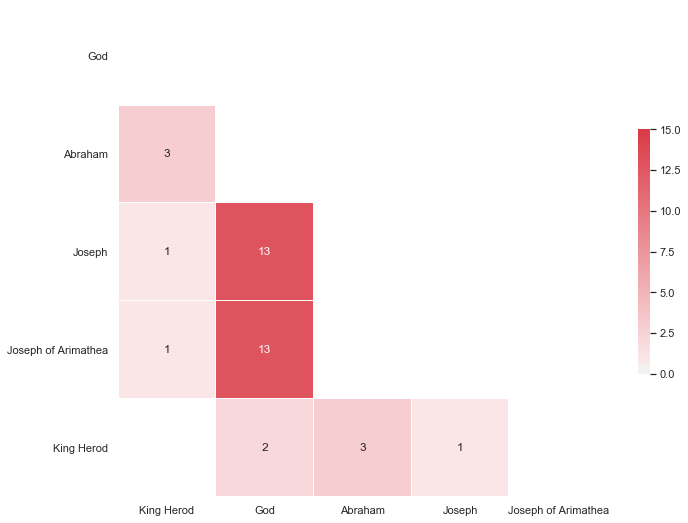

In [21]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(connsD, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(connsD, cmap=cmap, vmax=160, vmin=0,center=0,
            square=True,annot=True, linewidths=.5, cbar_kws={"shrink": .5})


## calculate relationship between locations
Similar to the character relationship analysis in the novel, the only difference is that in the process of analysis, the original place name replaces the name.


In [22]:
def extract_location_from_chapter(chapter):
    '''

    :param chapter: chapter to be analyzed
    :return: location_conns: connections between locations
    '''
    title = chapter[0]
    paragraphs = chapter[1:]
    entities = [(extract_location_from_text(paragraph), paragraph) for paragraph in paragraphs]
    entities = [pair for pair in entities if len(pair[0]) != 0]

    connections = {}
    for pair in entities:
        entity = set(pair[0])
        if len(entity) <= 1:
            continue
        entity = list(entity)
        for ind in range(0, len(entity)):
            for other_ind in range(ind + 1, len(entity)):
                a = entity[ind]
                b = entity[other_ind]
                if a not in connections:
                    connections[a] = {}
                if b not in connections[a]:
                    connections[a][b] = 0
                connections[a][b] += 1

                if b not in connections:
                    connections[b] = {}
                if a not in connections[b]:
                    connections[b][a] = 0
                connections[b][a] += 1

    return connections

In [23]:
def analyze_location_conns(path, location_path=""):
    document = read_doc_n_prep(path)
    document = split_chapters(document, "Chapter")
    locations = []
    with open(location_path) as file:
        locations = file.readlines()
        locations = [i.strip() for i in locations]
        #print(locations)
    if len(locations) != 0:
        location_conn = [extract_location_with_list(chapter, locations) for chapter in document]
    else:
        location_conn = [extract_location_from_chapter(chapter) for chapter in document]
    return location_conn

The numbers shown below are the relationship between locations, which is a list of location relationships. The strength between the numbers is shown. If we can see that their relationship between the two places "Israel" and "Galilee" is 2, it means that the relationship between the two locations appears in two sentences at the same time.

In [24]:
location = analyze_location_conns(narrative, locations)
[print(i,l) for i,l in enumerate(location)]

0 {'heaven': {'earth': 11}, 'earth': {'heaven': 11}, 'Allonbachuth': {'Bethel': 1}, 'Bethel': {'Allonbachuth': 1}}
1 {'heaven': {'earth': 3}, 'earth': {'heaven': 3}}
2 {'heaven': {'earth': 1}, 'earth': {'heaven': 1}}
3 {}
4 {'heaven': {'earth': 9}, 'earth': {'heaven': 9}}
5 {'heaven': {'earth': 1}, 'earth': {'heaven': 1}, 'Jericho': {'Bethel': 2}, 'Bethel': {'Jericho': 2}}
6 {'Edom': {'heaven': 1, 'earth': 1}, 'heaven': {'Edom': 1, 'earth': 1}, 'earth': {'Edom': 1, 'heaven': 1}}
7 {}
8 {'Bethlehem': {'Ephrath': 1}, 'Ephrath': {'Bethlehem': 1}}
9 {'heaven': {'earth': 1}, 'earth': {'heaven': 1}}
10 {'heaven': {'earth': 2}, 'earth': {'heaven': 2}, 'Jericho': {'Bethel': 1}, 'Bethel': {'Jericho': 1}}
11 {'heaven': {'earth': 1}, 'earth': {'heaven': 1}}
12 {'heaven': {'earth': 2}, 'earth': {'heaven': 2}}
13 {'heaven': {'earth': 3}, 'earth': {'heaven': 3}}
14 {'heaven': {'earth': 1}, 'earth': {'heaven': 1}}
15 {'heaven': {'earth': 1}, 'earth': {'heaven': 1}}
16 {}
17 {'heaven': {'earth': 1}, '

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

But there is only one list that has no way to make a graph. 

We need data in the form of a dataframe. 

So the function of this part is to convert the previously obtained list of location relationships into data in the form of dataframe.


In [25]:
# Sets the chapter where you want to view the relationship
chapter = 0
location = pd.DataFrame(location[chapter])
print(location)

              heaven  earth  Allonbachuth  Bethel
earth           11.0    NaN           NaN     NaN
heaven           NaN   11.0           NaN     NaN
Bethel           NaN    NaN           1.0     NaN
Allonbachuth     NaN    NaN           NaN     1.0


The numbers in the picture represent the relationship between the locatios.

We can see that in this example, the relationship between Heaven and Earth is 2, which is the deepest relationship between the characters in the full text. 

We can observe the depth of the relationship of the characters through the depth of the color. The darker the color, the closer the relationship between the locations.

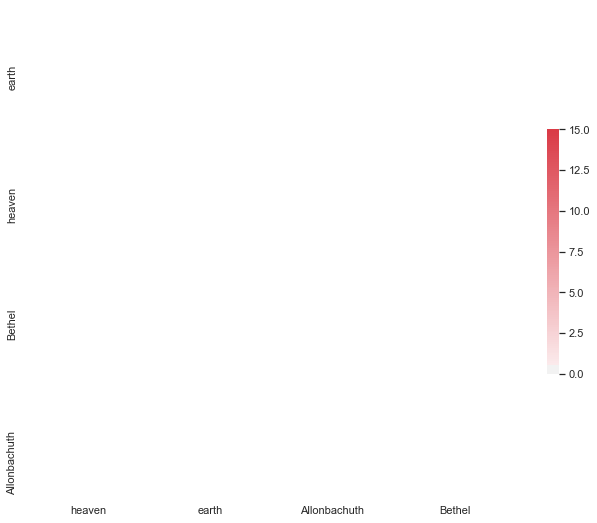

In [26]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(location, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(location, mask=mask, cmap=cmap, vmax=15, vmin=0,center=0,
            square=True,annot=True, linewidths=.5, cbar_kws={"shrink": .5})


# Get Sentence Sentiment

Now let's begin to make a visualization of Sentence Sentiment. This section is analyzed using the python `TextBlob` lirbrary.

We are going to use `TextBlob` to get sentence sentiment in this section.
Let's check these function by using `TextBlob`

In [27]:
sentenceExample = "There were giants in the earth in those days; and also after that, when the sons of God came in unto the daughters of men, and they bare children to them, the same became mighty men which were of old, men of renown"

In [28]:
exampleSentiment = TextBlob(sentenceExample).sentiment
print(exampleSentiment)

Sentiment(polarity=0.1375, subjectivity=0.33125)


Now we can see that we have given us two values for the `TextBlob` analysis. `(polarity=1.0, subjectivity=1.0)` 

We can see that polarity is 1.0, which means that the statement is positive and 1.0 subjectivity refers that mostly it is a public opinion and not a factual information.

In [29]:
def sentiment_analysis_of_sentence(sentence):
    '''

    :param sentence: sentence waiting to be processed, a list of tokens
    :return: sentiment polarity
    '''
    return TextBlob(sentence).sentiment.polarity


In [30]:
def extract_sentiment_from_chapter(chapter):
    '''

    :param chapter: chapter waiting to be processed, a list of sentences
    :return: [(sentence,sentiment)]
    '''
    title = chapter[0]
    sentences = [sentence for paragraph in chapter[1:] for sentence in sent_tokenize(paragraph)]
    sentiments = [(sentence, sentiment_analysis_of_sentence(sentence)) for sentence in sentences]
    
    return sentiments

The function of this function `analyze_sents` is to analyze the emotions in each sentence of the novel through different chapters.

Extract the different chapters in the article through the previously set functions `split_chapters`, and then separate the chapters, and put the emotions of each sentence in each chapter into the parameter `sentiment`.

In [31]:
def analyze_sents(path):
    document =read_doc_n_prep(path)
    document = split_chapters(document, "Chapter")
    sentiment = [extract_sentiment_from_chapter(chapter) for chapter in document]
    return sentiment

In [32]:
sents = analyze_sents(narrative)
sentimentD = pd.DataFrame(sents[1])
print(sentimentD)
print(type(sentimentD))

                                                      0    1
0     1:1 Now these are the names of the children of...  0.0
1     into Egypt; every man and his household came w...  0.0
2     1:2 Reuben, Simeon, Levi, and Judah, 1:3 Issac...  0.0
3      Benjamin, 1:4 Dan, and Naphtali, Gad, and Asher.  0.0
4     1:5 And all the souls that came out of the loi...  0.0
...                                                 ...  ...
3129  cloud were not taken up, then they journeyed n...  0.0
3130                                      was taken up.  0.0
3131  40:38 For the cloud of the LORD was upon the t...  0.0
3132  fire was on it by night, in the sight of all t...  0.0
3133                     throughout all their journeys.  0.0

[3134 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>


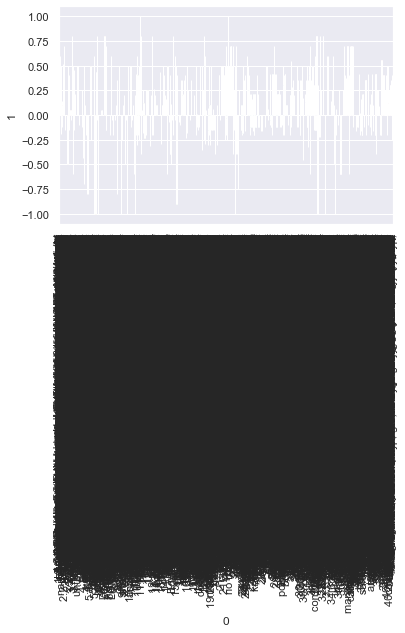

In [33]:

sns.set(style="darkgrid")

# Load an example dataset with long-form data
# fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
ax1 = sns.barplot(x=0, y=1,data=sentimentD)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)



# Calculate similarity between chapters

This part of the function is to understand the similarities between the chapters.


**Tips** : For anyone interested in the details behind the TF-IDF process [I've got more information here.](https://nbviewer.jupyter.org/github/adelr/hcaproximity/blob/master/Proximity_and_Neighbourhood.ipynb)

As well as, here is [information for Cosine Similarity.](https://www.machinelearningplus.com/nlp/cosine-similarity/)

## calculate similarity between chapters
By using TF-IDF and Cosine Similarity, we will got the similarity between chapters. This is a call `analyze_cohesive` to calculate similarity between sections. Here is an example of how we can get a lot of Numbers between 0 and 1 by printing them out. Given the size of the bible this may take some time. 
- For example, in the case of Bible, there are 66 chapters. In the first array, there are 66 Numbers, which represent the similarity between the first chapter and the corresponding 66 chapters.  We can see that the  number in column 3, 0.971380 , represents the similarities between chapter 1 and sheet 3 at 97.14 percent

In [34]:
def analyze_cohesive(path):
    document = read_doc_n_prep(path)
    document = split_chapters(document, "Chapter")
    document_cohesiveness = [cohesiveness_between_chapters(document)]
    document_cohesiveness = np.array(document_cohesiveness)
    return document_cohesiveness

Expect TF-IDF and Cosine Similarity, we also use Latent Semantic Index model to analysis.

**Latent Semantic Index (LSI)**, also known as Latent Semantic Analysis (LSA), is mainly used to solve two types of problems. One is polysemy. For example, the term “bank” can refer to a bank or a river bank. One type is a multi-word, that is, a synonym problem, such as "car" and "automobile" have the same meaning, if in the process of retrieval, in calculating the similarity of these two types of problems, relying on the method of cosine similarity will This problem cannot be handled very well. Therefore, a method of latent semantic indexing is proposed, which uses SVD dimension reduction to map terms and texts to a new space

In [35]:
def cohesiveness_between_chapters(document):
    '''
    Compute cohesiveness between chapters using latent semantic analysis
    :param document: document to be processed, a list of chapters.
    :return: cohesivess matrix
    '''
    document = [' '.join(chapter) for chapter in document]

    document = [remove_stopwords(chapter).split() for chapter in document]
    dictionary = corpora.Dictionary(document)

    corpus = [dictionary.doc2bow(chapter) for chapter in document]

    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]

    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
    corpus_lsi = lsi[corpus_tfidf]

    index = similarities.MatrixSimilarity(corpus_lsi)
    sims = index[corpus_lsi]
    # index = similarities.MatrixSimilarity(corpus_tfidf)// Similarity with tf-idf
    # sims = index[corpus_tfidf]
    #print(index)
    #print(sims)
    return sims


This set of data is a cosine similarity in the form of a dataframe. *note the numbers on line 2 of this block of code refer to the number of chapters in the text being analysed. 

In [36]:
cohesiveness = analyze_cohesive(narrative)
cohesiveness= np.reshape(cohesiveness,(-1,66))
cohesiveness = pd.DataFrame(cohesiveness)
print(cohesiveness)

          0         1         2         3         4         5         6   \
0   1.000000  0.980474  0.986824  0.971380  0.986369  0.959085  0.990170   
1   0.980474  1.000000  0.999372  0.999123  0.999467  0.996033  0.998341   
2   0.986824  0.999372  1.000000  0.997013  0.999996  0.992256  0.999754   
3   0.971380  0.999123  0.997013  1.000000  0.997224  0.998885  0.995054   
4   0.986369  0.999467  0.999996  0.997224  1.000000  0.992598  0.999688   
..       ...       ...       ...       ...       ...       ...       ...   
61  0.346687  0.155463  0.190358  0.113964  0.187619  0.066943  0.212087   
62  0.238338  0.042700  0.078064  0.000830  0.075283 -0.046374  0.100159   
63  0.498365  0.318144  0.351527  0.278169  0.348914  0.232520  0.372206   
64  0.337470  0.145765  0.180719  0.104213  0.177975  0.057152  0.202491   
65  0.866354  0.751224  0.774134  0.722928  0.772365  0.689509  0.787985   

          7         8         9   ...        56        57        58        59  \
0   0.

After getting the data in the form of dataframe, we pass it to the heatmap chart. The triangle below is formed to show the similarity between the chapters.
The darker the color, the higher the similarity. Through this picture we can see that the whole novel is talking about the same thing. Of course, it is obvious that there are also several blue squares in the triangle, which represents the negative correlation between the chapters. This proves that after calculation by the TF-IDF and Cosine Similarity algorithm, we believe that there is a negative correlation between the chapters, which only proves that there is little keywords in the chapters are particularly similar.

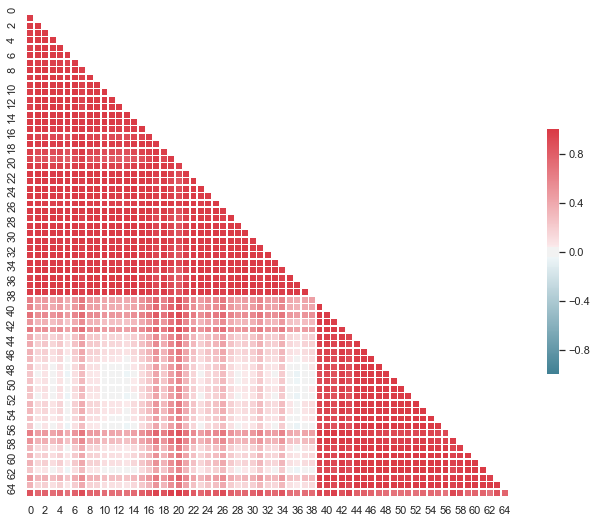

In [37]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(cohesiveness, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cohesiveness, mask=mask, cmap=cmap, vmax=1, vmin=-1,center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


Note the changes in colour directly relate show the changes in the Bible from the Gospels to the Acts of the Apostles and the Epistles. 

## Attribution

This notebook has been adapted from the work of Yuying Pei in 2019. 